# NHDPlus and Accumulation

In [1]:
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import pynhd as nhd
from pynhd import NLDI, NHDPlusHR, WaterData

In [2]:
import warnings

warnings.filterwarnings("ignore")

[PyNHD](https://github.com/cheginit/pynhd) provides access to the Hydro Network-Linked Data Index ([NLDI](https://labs.waterdata.usgs.gov/about-nldi/index.html)) and the [WaterData](https://labs.waterdata.usgs.gov/geoserver/web/wicket/bookmarkable/org.geoserver.web.demo.MapPreviewPage?1) web services for navigating and subsetting [NHDPlus](https://nhdplus.com/NHDPlus) V2 database. Additionally, you can download NHDPlus High Resolution data as well.

First, let's get the watershed geometry of the contributing basin of a USGS station using `NLDI`:

In [3]:
nldi = NLDI()
station_id = "01031500"

basin = nldi.get_basins(station_id)

The `navigate_byid` class method can be used to navigate NHDPlus in both upstream and downstream of any point in the database. The available feature sources are ``comid``, ``huc12pp``, ``nwissite``, ``wade``, ``wqp``. Let's get ComIDs and flowlines of the tributaries and the main river channel in the upstream of the station.

In [4]:
flw_main = nldi.navigate_byid(
    fsource="nwissite",
    fid=f"USGS-{station_id}",
    navigation="upstreamMain",
    source="flowlines",
    distance=1000,
)

flw_trib = nldi.navigate_byid(
    fsource="nwissite",
    fid=f"USGS-{station_id}",
    navigation="upstreamTributaries",
    source="flowlines",
    distance=1000,
)

We can get other USGS stations upstream (or downstream) of the station and even set a distance limit (in km):

In [5]:
st_all = nldi.navigate_byid(
    fsource="nwissite",
    fid=f"USGS-{station_id}",
    navigation="upstreamTributaries",
    source="nwissite",
    distance=1000,
)

st_d20 = nldi.navigate_byid(
    fsource="nwissite",
    fid=f"USGS-{station_id}",
    navigation="upstreamTributaries",
    source="nwissite",
    distance=20,
)

Now, let's get the [HUC12 pour points](https://www.sciencebase.gov/catalog/item/5762b664e4b07657d19a71ea):

In [6]:
pp = nldi.navigate_byid(
    fsource="nwissite",
    fid=f"USGS-{station_id}",
    navigation="upstreamTributaries",
    source="huc12pp",
    distance=1000,
)

Let's plot the vector data:

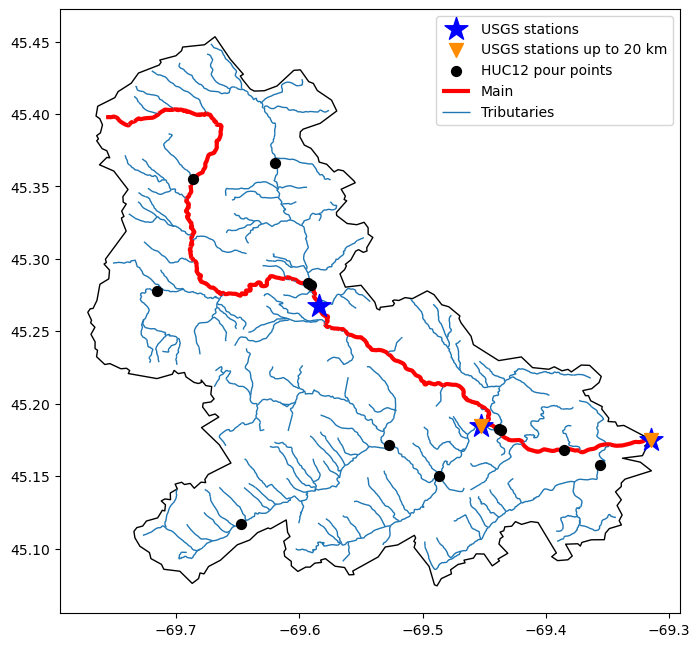

In [7]:
ax = basin.plot(facecolor="none", edgecolor="k", figsize=(8, 8))
st_all.plot(
    ax=ax, label="USGS stations", marker="*", markersize=300, zorder=4, color="b"
)
st_d20.plot(
    ax=ax,
    label="USGS stations up to 20 km",
    marker="v",
    markersize=100,
    zorder=5,
    color="darkorange",
)
pp.plot(
    ax=ax, label="HUC12 pour points", marker="o", markersize=50, color="k", zorder=3
)
flw_main.plot(ax=ax, lw=3, color="r", zorder=2, label="Main")
flw_trib.plot(ax=ax, lw=1, zorder=1, label="Tributaries")
ax.legend(loc="best")
ax.set_aspect("auto")
ax.figure.set_dpi(100)

Now, let's use [WaterData](https://labs.waterdata.usgs.gov/geoserver/web/) service to get the headwater catchments for this basin:

In [8]:
wd = WaterData("catchmentsp")
cat = wd.bygeom(basin.geometry[0], predicate="OVERLAPS")

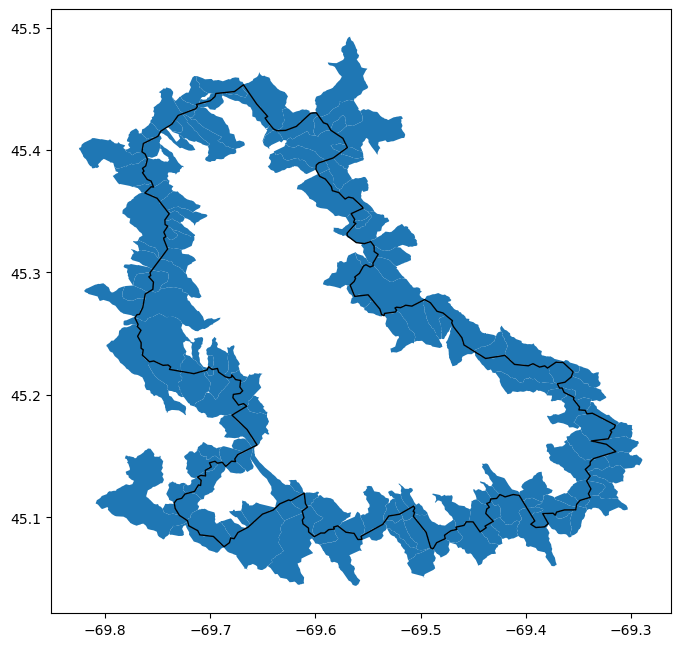

In [9]:
ax = cat.plot(figsize=(8, 8))
basin.plot(ax=ax, facecolor="none", edgecolor="k")
ax.set_aspect("auto")
ax.figure.set_dpi(100)

We can also use the WaterData service to get the medium- and `NHDPlusHR` to retrieve high-resolution flowlines within the bounding box of this watershed and compare them.

In [10]:
mr = WaterData("nhdflowline_network")
nhdp_mr = mr.bybox(basin.geometry[0].bounds)

hr = NHDPlusHR("networknhdflowline")
nhdp_hr = hr.bygeom(basin.geometry[0].bounds)

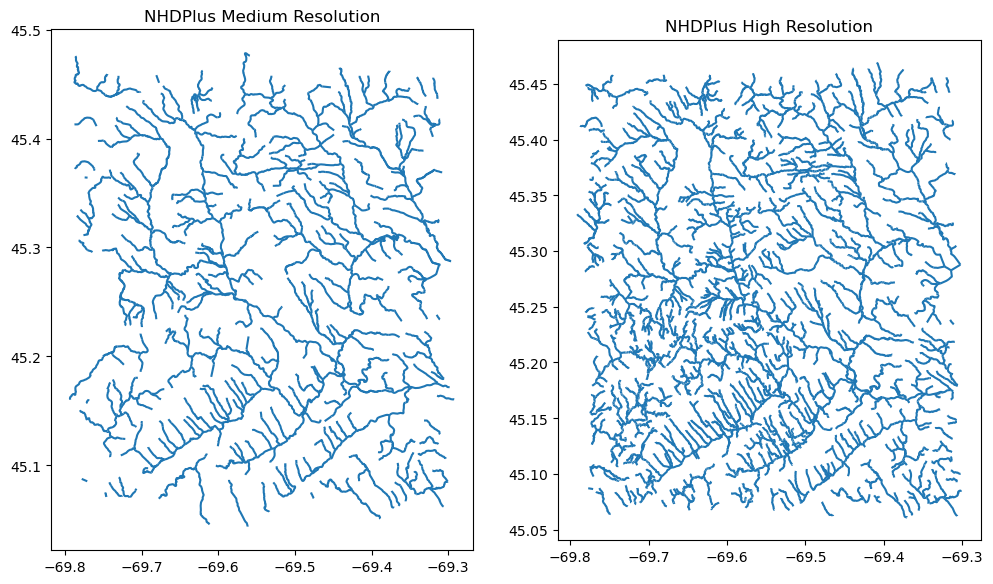

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), dpi=100)

nhdp_mr.plot(ax=ax1)
ax1.set_title("NHDPlus Medium Resolution")
nhdp_hr.plot(ax=ax2)
ax2.set_title("NHDPlus High Resolution");

Since NHDPlus HR is still at the pre-release stage let's use the MR flowlines to demonstrate the vector-based accumulation.

Based on a topological sorted river network ``pynhd.vector_accumulation`` computes flow accumulation in the network. It returns a dataframe which is sorted from upstream to downstream that shows the accumulated flow in each node.

PyNHD has a utility called ``prepare_nhdplus`` that identifies such relationship among other things such as fixing some common issues with NHDPlus flowlines. But first we need to get all the NHDPlus attributes for each ComID since `NLDI` only provides the flowlines' geometries and ComIDs which is useful for navigating the vector river network data. For getting the NHDPlus database we use ``WaterData``. The WaterData web service layers are  ``nhdflowline_network``, ``nhdarea``, ``nhdwaterbody``, ``catchmentsp``, ``gagesii``, ``huc08``, ``huc12``, ``huc12agg``, and ``huc12all``. Let's use the ``nhdflowline_network`` layer to get required info.

In [12]:
wd = WaterData("nhdflowline_network")

comids = flw_trib.nhdplus_comid.to_list()
nhdp_trib = wd.byid("comid", comids)
flw = nhd.prepare_nhdplus(nhdp_trib, 0, 0, purge_non_dendritic=False)

The NLDI service includes more than 30 NHDPlus catchment-scale attributes that are associated with NHDPlus ComIDs. Values of these attributes are provided in three characteristic types:

1. ``local``: For individual reach catchments,
2. ``tot``: For network-accumulated values using total cumulative drainage area,
3. ``div``: For network-accumulated values using divergence-routed.

You can get a list available attributes for each characteristic type using ``nldi.get_validchars``:

In [13]:
nldi.get_validchars("local").head()

characteristic_description    units  \
CAT_BFI      Base Flow Index (BFI), The BFI is a ratio of b...  percent   
CAT_CONTACT  Subsurface flow contact time index. The subsur...     days   
CAT_ET       Mean-annual actual evapotranspiration (ET), es...  mm/year   
CAT_EWT      Average depth to water table relatice to the l...   meters   
CAT_HGA      Percentage of Hydrologic Group A soil. -9999 d...  percent   

            dataset_label                                        dataset_url  \
CAT_BFI                    https://www.sciencebase.gov/catalog/item/5669a...   
CAT_CONTACT                https://www.sciencebase.gov/catalog/item/56f96...   
CAT_ET                     https://www.sciencebase.gov/catalog/item/57054...   
CAT_EWT                    https://www.sciencebase.gov/catalog/item/56f97...   
CAT_HGA                    https://www.sciencebase.gov/catalog/item/5728d...   

            theme_label                                          theme_url  \
CAT_BFI      Hydrologic  https://www.sciencebase.gov/catalog/item/5669a...   
CAT_CONTACT  Hydrologic  https://www.sciencebase.gov/catalog/item/5669a...   
CAT_ET          Climate  https://www.sciencebase.gov/catalog/item/566ef...   
CAT_EWT      Hydrologic  https://www.sciencebase.gov/catalog/item/5669a...   
CAT_HGA           Soils  https://www.sciencebase.gov/catalog/item/568d6...   

            characteristic_type  
CAT_BFI         localCatch_name  
CAT_CONTACT     localCatch_name  
CAT_ET          localCatch_name  
CAT_EWT         localCatch_name  
CAT_HGA         localCatch_name

Let's get Mean Annual Groundwater Recharge, ``CAT_RECHG``, using ``getcharacteristic_byid`` class method and carry out with the flow accumulation.

In [14]:
char = "CAT_RECHG"
area = "areasqkm"

local = nldi.getcharacteristic_byid(comids, "local", char_ids=char)
flw = flw.merge(local[char], left_on="comid", right_index=True)


def runoff_acc(qin, q, a):
    return qin + q * a


flw_r = flw[["comid", "tocomid", char, area]]
runoff = nhd.vector_accumulation(flw_r, runoff_acc, char, [char, area])


def area_acc(ain, a):
    return ain + a


flw_a = flw[["comid", "tocomid", area]]
areasqkm = nhd.vector_accumulation(flw_a, area_acc, area, [area])

runoff /= areasqkm

In [15]:
char_df = nldi.characteristics_dataframe("local", "CAT_RECHG", "RECHG_CONUS.zip")
local = char_df[char_df.COMID.isin(comids)].set_index("COMID")

Since these are catchment-scale characteristic, let's get the catchments then add the accumulated characteristic as a new column and plot the results.

In [16]:
wd = WaterData("catchmentsp")
catchments = wd.byid("featureid", comids)

c_local = catchments.merge(local, left_on="featureid", right_index=True)
c_acc = catchments.merge(runoff, left_on="featureid", right_index=True)

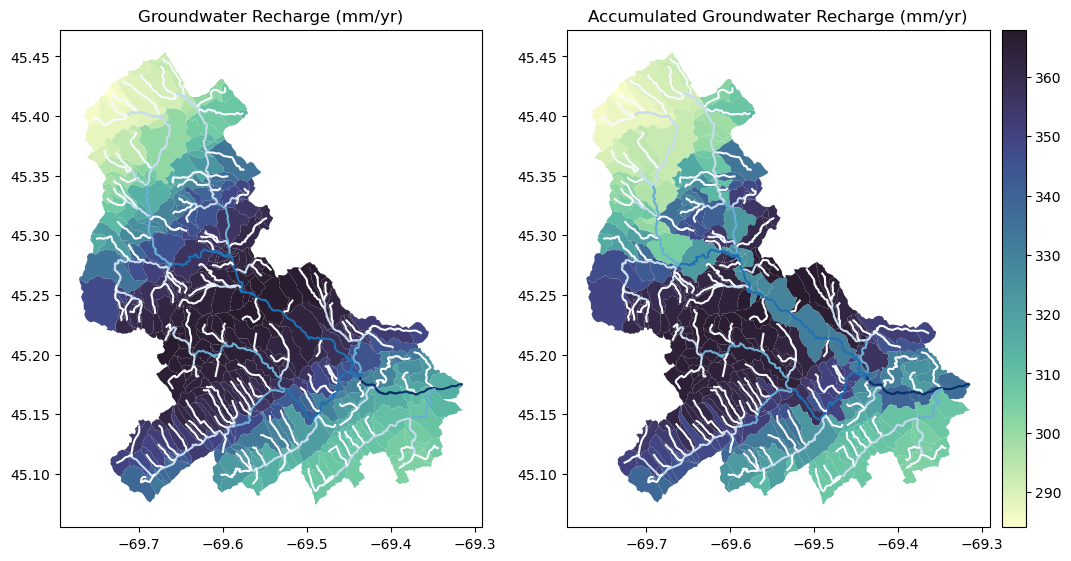

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), dpi=100)

cmap = cmo.deep
norm = plt.Normalize(vmin=c_local.CAT_RECHG.min(), vmax=c_acc.acc_CAT_RECHG.max())

c_local.plot(ax=ax1, column=char, cmap=cmap, norm=norm)
flw.plot(ax=ax1, column="streamorde", cmap="Blues", scheme="fisher_jenks")
ax1.set_title("Groundwater Recharge (mm/yr)")

c_acc.plot(ax=ax2, column=f"acc_{char}", cmap=cmap, norm=norm)
flw.plot(ax=ax2, column="streamorde", cmap="Blues", scheme="fisher_jenks")
ax2.set_title("Accumulated Groundwater Recharge (mm/yr)")

cax = fig.add_axes(
    [
        ax2.get_position().x1 + 0.01,
        ax2.get_position().y0,
        0.02,
        ax2.get_position().height,
    ]
)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm, cax=cax);